In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [ ]:
# create a words variable that opens, reads, splitlines the file 'names.txt'
words = open('names.txt').read().splitlines()

# create a sorted list from a set of letters found in the words variable
letters = sorted(list(set(''.join(words))))

# create a dictionary of letters with their index in the letters list where a = 1
letter_to_index = {letter: i + 1 for i, letter in enumerate(letters)}
letter_to_index['.'] = 0

# create a dictionary of indices with their letter where 1 = a
index_to_letter = {i: letter for letter, i in letter_to_index.items()}

# create a torch generator with a manual seed value
g = torch.Generator().manual_seed(2147483647)

# split the words into a training, validation, and test set of bigrams
xs_train, ys_train = [], []

# shuffle the indices of the words
indices = torch.randperm(len(words), generator=g)

# iterate through the first 80% of the indices
# for i in indices[:int(len(indices) * 0.8)]:
for i in indices[:int(len(indices) * 0.8)]:
    # create a chs variable converts the word to a list of characters 
    # and adds a '.' to the beginning and end
    chs = ['.'] + list(words[i]) + ['.']
    # iterate through the first and second characters for a zip of the characters, 
    # and the characters after the first character
    for ch1, ch2 in zip(chs, chs[1:]):
        # append the index of the first character to the xs_train variable
        xs_train.append(letter_to_index[ch1])
        # append the index of the second character to the ys_train variable
        ys_train.append(letter_to_index[ch2])

# create a validation list of words and a test list of words
xs_valid, xs_test = [], []

# iterate through the next 10% of the indices and add the words to the validation list
for i in indices[int(len(indices) * 0.8):int(len(indices) * 0.9)]:
    xs_valid.append(words[i])

# iterate through the last 10% of the indices and add the words to the test list
for i in indices[int(len(indices) * 0.9):]:
    xs_test.append(words[i])

# create a torch tensor of dtype int64 from the lists created above
# and put each definition on a new line
xs_train = torch.tensor(xs_train)
ys_train = torch.tensor(ys_train)

xs_train_num = xs_train.nelement()

In [ ]:
# randomly initialize a weight matrix of size 27x27 using the g generator
# and put each definition on a new line
W = torch.randn((27, 27), generator=g, requires_grad=True)

# take each xs tensor from the previous block and create a new variable for the tensor
# the variable name should show that it is an encoded value created from
# a one hot encoding of the tensor, with num_classes of 27
# and chain the return of one_hot to a float
xs_train_onehot = F.one_hot(xs_train, num_classes=27).float()

for k in range(1000):
  # forward pass
  #====================

  # predict log-counts
  logits = xs_train_one_hot @ W

  # compute log-probabilities
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdim=True)

  # the equivalent of the above two lines but using the softmax function
  # log_probs = F.softmax(logits, dim=1)
  # print(log_probs)

  # compute the loss
  loss = -probs[torch.arange(xs_train_num), ys_train].log().mean() + 0.01 * W.pow(2).mean()
  print(loss.item())

  # backward pass
  #====================

  # zero the gradient
  W.grad = None

  # compute the gradient
  loss.backward()

  # update the weights
  W.data += -50 * W.grad


In [ ]:
for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(index_to_letter[ix])
    if ix == 0:
      break
  print(''.join(out))

In [295]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

class BigramModel():
    # initialize your data structures in the constructor
    def __init__(self, corpus, generator, trainValTestSplit = [0.8, 0.1, 0.1]):
        self.corpus = open(corpus, 'r').read().splitlines()
        self.letters = sorted(list(set(''.join(self.corpus))))
        self.trainValTestSplit = trainValTestSplit
        self.generator = generator
        self.indices = torch.randperm(len(self.corpus), generator=self.generator)

        self.letter_to_index = {letter: index for index, letter in enumerate(self.letters)}
        self.letter_to_index['.'] = 0
        self.index_to_letter = {i: letter for letter, i in self.letter_to_index.items()}
        
        self.W = torch.randn((27,27), generator=self.generator, requires_grad=True)

        self.xs_train, self.ys_train = [], []
        self.xs_valid, self.ys_valid = [], []
        self.xs_test, self.ys_test = [], []
        
        self.train_words, self.valid_words, self.test_words = [], [], []

        self.setup_train()
        self.setup_valid()
        self.setup_test()

        self.train_losses = []
        self.valid_losses = []

    def setup_train(self):
        for i in self.indices[:int(len(self.indices) * self.trainValTestSplit[0])]:
            self.train_words.append(self.corpus[i])
            
        for w in self.train_words:    
            chs = ['.'] + list(w) + ['.']
            # iterate through the first and second characters for a zip of the characters, 
            # and the characters after the first character
            for ch1, ch2 in zip(chs, chs[1:]):
                # append the index of the first character to the xs_train variable
                self.xs_train.append(self.letter_to_index[ch1])
                # append the index of the second character to the ys_train variable
                self.ys_train.append(self.letter_to_index[ch2]) 
        
        self.xs_train = torch.tensor(self.xs_train)
        self.ys_train = torch.tensor(self.ys_train)
        self.xs_train_num = self.xs_train.nelement()
        self.xs_train_encoded =F.one_hot(self.xs_train, num_classes=27).float()

    def setup_valid(self):
        for i in self.indices[int(len(self.indices) * self.trainValTestSplit[0]):int(len(self.indices) * (self.trainValTestSplit[0] + self.trainValTestSplit[1]))]:
            self.valid_words.append(self.corpus[i])
        
        for w in self.valid_words:
            chs = ["."] + list(w) + ["."]
            for ch1, ch2 in zip(chs, chs[1:]):
                self.xs_valid.append(self.letter_to_index[ch1])
                self.ys_valid.append(self.letter_to_index[ch2])
        
        self.xs_valid = torch.tensor(self.xs_valid)
        self.ys_valid = torch.tensor(self.ys_valid)
        self.xs_valid_num = self.xs_valid.nelement()
        self.xs_valid_encoded = F.one_hot(self.xs_valid, num_classes=27).float()


    def setup_test(self):
        for i in self.indices[int(len(self.indices) * (self.trainValTestSplit[0] + self.trainValTestSplit[1])):]:
            self.test_words.append(self.corpus[i])

    def train_pass(self, epochs):
        loss = 0
        for epoch in range(epochs):
            log_counts = self.xs_train_encoded @ self.W
            exp_counts = log_counts.exp()
            probz = exp_counts / exp_counts.sum(dim=1, keepdim=True)

            self.xs_train_probabilities = probz

            lossz = -probz[torch.arange(self.xs_train_num), self.ys_train].log().mean() + 0.001 * self.W.pow(2).mean()
            loss = lossz.item()
            self.train_losses.append(loss)
            self.W.grad = None
            lossz.backward()

            self.W.data += -50 * self.W.grad
        
        # plot the self.train_losses variable
        plt.plot(self.train_losses)
        
        
        return loss
    
    def validation_pass(self, epochs):
        loss = 0
        for epoch in range(epochs):
            log_counts = self.xs_valid_encoded @ self.W
            exp_counts = log_counts.exp()
            probz = exp_counts / exp_counts.sum(dim=1, keepdim=True)

            self.xs_valid_probabilities = probz

            lossz = -probz[torch.arange(self.xs_valid_num), self.ys_valid].log().mean() + 0.001 * self.W.pow(2).mean()
            loss = lossz.item()
            self.valid_losses.append(loss)
            self.W.grad = None
            lossz.backward()

            self.W.data += -50 * self.W.grad
        
        # plot the self.valid_losses and the self.train_losses variables
        plt.plot(self.valid_losses)
        plt.plot(self.train_losses)

        return loss
        
    def generate(self, count):
        for i in range(5):
            out = []
            ix = 0
            while True:
                xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
                logits = xenc @ W # predict log-counts
                counts = logits.exp() # counts, equivalent to N
                p = counts / counts.sum(1, keepdims=True) # probabilities for next character
                # ----------
                
                ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
                out.append(index_to_letter[ix])
                if ix == 0:
                    break
            print(''.join(out[:-1]))

In [298]:
bigam = BigramModel('names.txt', g)

2.3566830158233643

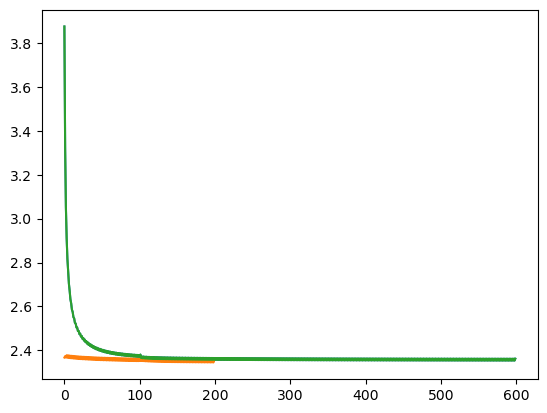

In [300]:
bigam.train_pass(500)
bigam.validation_pass(100)

In [301]:
bigam.generate(5)

zan
sh
fiapeyliaiagnnngaq
pxprilorai
ka
